# Inverted Pendulum

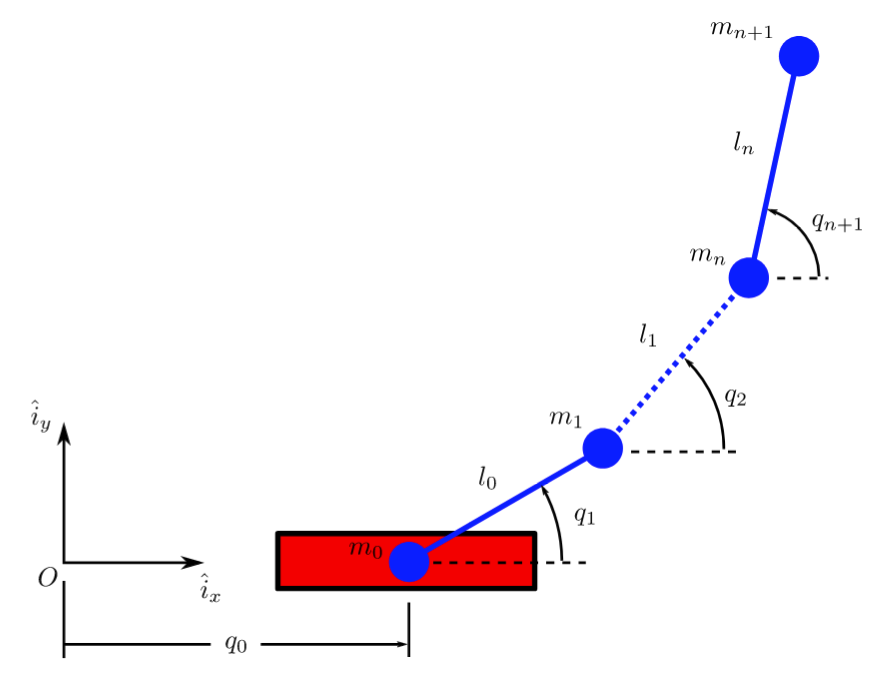

In [38]:
import sympy 
from sympy import symbols 
from sympy.physics.mechanics import *
import sympy.physics.mechanics as mech
mech.init_vprinting()

In [39]:
#Anzahl der Pendelglieder (Verbindungspunkte)
n = 1

In [40]:
#Generelle Koordinaten
q = dynamicsymbols('q:' + str(n+1))

#Geschwindigkeiten
v = dynamicsymbols('v:' + str(n+1))

#Kraft auf Wagen
f = dynamicsymbols('f')

In [41]:
#Masse von Pendelglieder
m = symbols('m:' + str(n+1))

#Pendellänge des jeweiligen Glieds
l = symbols('l:' + str(n))

#Erdbeschleunigung und Zeit
g, t = symbols('g t')

In [42]:
#Frames
#Inertial reference
I = ReferenceFrame('I')

#Ursprungspunkt 
O = Point('O')

#G's Geschwindigkeit ist 0
O.set_vel(I, 0)

In [43]:
#Bewegung des Wagens
A = Point('A')            #Drehpunkt Pendel - Wagen (kann sich nur horizontal bewegen)
A.set_pos(O, q[0]*I.x)    #Position von Punkt A
A.set_vel(I, v[0]*I.x)    #Geschwindigkeit von A

Pa_0 = Particle('Pa_0', A, m[0])  #Particle 1

In [44]:
# Für mehrgliedrige Pendel
frames = [I]       #Liste für n+1 Frames
points = [A]       #Liste für n+1 Pendelanhangspunkte 
particles = [Pa_0]  #Liste für n+1? Particles
forces = [(A, f*I.x - m[0]*g*I.y)]  #Liste der aufgebrachten Kräfte inkl. F
kindiffs = [q[0].diff(t) - v[0]]    #Liste für Kinematik ODE's

# Für mehrgliedrige Pendel
for i in range(n):
    Bi = I.orientnew('B' + str(i), 'Axis', [q[i+1], I.z])  #Neuer Frame
    Bi.set_ang_vel(I, v[i+1] * I.z)                        #Setze Winkelgeschwindigkeit
    frames.append(Bi)                                      #Zu Frame-Liste anhängen
    
    Pi = points[-1].locatenew('P' + str(i+1), l[i]*Bi.x)   #Neuer Punkt
    Pi.v2pt_theory(points[-1], I, Bi)                      #Setze Geschwindigkeit
    points.append(Pi)                                      #Zu Punkt-Liste hinzufügen
    
    Pai = Particle('Pa' + str(i+1), Pi, m[i+1])            #Neuer Particle
    particles.append(Pai)                                  #Zu List hinzufügen
    
    forces.append((Pi, -g * m[i+1] * I.y))                 #(Schwer)Kraft am Punkt Pi
    
    kindiffs.append(q[i+1].diff(t) - v[i+1])               #Kinematiks ODE dq_i/dt - v_i = 0
    

In [45]:
print(particles)

[Pa_0, Pa1]


In [46]:
#DGL mit Kanes und allen Punktgeschwindigkeiten und Particlemassen definiert
kane = KanesMethod(I, q_ind=q, u_ind=v, kd_eqs=kindiffs)   #Objekte initialisiert
fr, frstar = kane.kanes_equations(particles, forces)       #Generiert EoM's Fr + Fr* = 0,

In [47]:
fr

⎡       f        ⎤
⎢                ⎥
⎣-g⋅l₀⋅m₁⋅cos(q₁)⎦

In [48]:
frstar

⎡        2                                          ⎤
⎢l₀⋅m₁⋅v₁ ⋅cos(q₁) + l₀⋅m₁⋅sin(q₁)⋅v₁̇ - (m₀ + m₁)⋅v₀̇⎥
⎢                                                   ⎥
⎢              2                                    ⎥
⎣          - l₀ ⋅m₁⋅v₁̇ + l₀⋅m₁⋅sin(q₁)⋅v₀̇           ⎦

In [49]:
# Simulation
from sympy import Dummy, lambdify
from numpy import array, hstack, zeros, linspace, pi, ones
from numpy.linalg import solve
from scipy.integrate import odeint

In [50]:
#Numerische Werte übergeben
arm_length = 1.0 / n    #Max. Pendellänge = 1m 
pend_mass = 0.01 / n    #max. Masse = 10Gramm
parameters = [g, m[0]]  #Gravitation und erstes Glied
parameter_vals =  [9.81, 0.01 / n]  #Numerische Werte

for i in range(n):      #Glieder Massen und Längen
    parameters += [l[i], m[i+1]]
    parameter_vals += [arm_length, pend_mass]

In [51]:
#Integrieren der Symbole in DGL
dynamic = q + v         #State - Liste
dynamic.append(f)       #Hinzufügen der Eingangskraft
dummy_symbols = [Dummy() for i in dynamic]   #Dummysymbol für jede Variable
dummy_dict = dict(zip(dynamic, dummy_symbols))
kindiff_dict = kane.kindiffdict()            #Gelöste kinematische DGLs

M = kane.mass_matrix_full.subs(kindiff_dict).subs(dummy_dict)  #Umwandlung zu Massenmatrix
F = kane.forcing_full.subs(kindiff_dict).subs(dummy_dict)      #Ersetze Kraftvektor

M_func = lambdify(dummy_symbols + parameters, M)               #Ausführbare Funktion für M
F_func = lambdify(dummy_symbols + parameters, F)               #Ausführbare Funktion für F

In [52]:
#Integrate ODE's mit Funktion, um die Ableitungen aktueller Zustände zu berechnen
def der_state(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    v = 0.0
    arguments = hstack((x, v, args))  #States, Input, Params
    dx = array(solve(M_func(*arguments), F_func(*arguments))).T[0]   #Solving for derivatives
    return dx

In [53]:
#Eingabewert
t1 = 10
samples = 100
x0 = hstack((0, pi / 2 * ones(len(q) - 1), 1e-3 * ones(len(v)) ))  # Initial conditions, q and v
#x0 = hstack((0, 0, 0, 0))
t = linspace(0, t1, samples)                                          # Time vector
ans = odeint(der_state, x0, t, args=(parameter_vals,))         # Actual integration

In [54]:
x = ans.T[0]
theta = ans.T[1]

In [55]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from matplotlib.animation import PillowWriter
%matplotlib inline
#%matplotlib notebook # --> animation im Jupyter Notebook

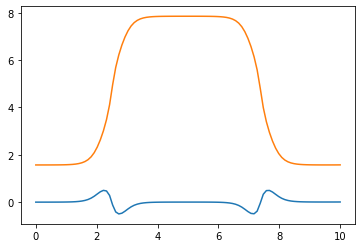

In [56]:
plt.plot(t, x, t, theta)

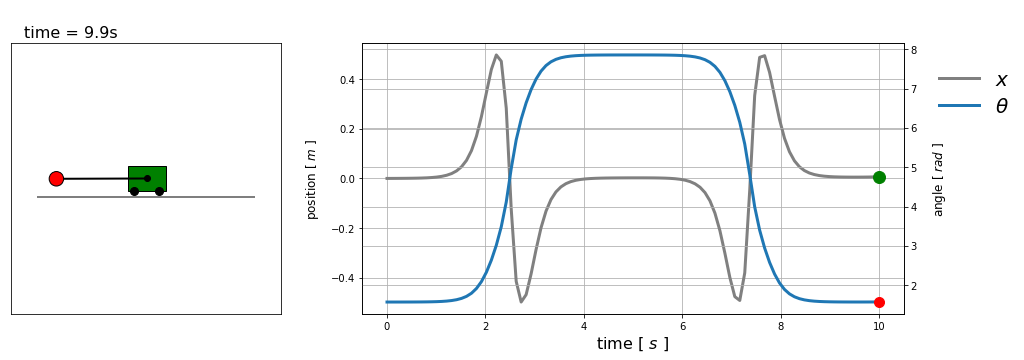

In [57]:
l = 1
from numpy import sin, cos

fig = plt.figure(figsize=(16,5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

# Title
string = r"%s "%(' ')
fig.suptitle(string, fontsize=24)

# Pendelplot
ax1 = fig.add_subplot(gs[0, 0], autoscale_on=True, xlim=(-l*1.5, l*1.5), ylim=(-l*1.5, l*1.5)) 
ax1.get_xaxis().set_ticks([]) # enable this to hide x axis ticks
ax1.get_yaxis().set_ticks([]) # enable this to hide y axis ticks

# Wagen
cart_w, cart_h = 0.42, 0.28 # Breite, Höhe, Raddurchmesser
cart = ax1.add_patch(Rectangle((0, 0), 0, 0, linewidth=1, edgecolor='k', facecolor='g'))
wheels, = ax1.plot([], [], 'ok', markersize=8) 
ground, = ax1.plot([-1.2,1.2], [-(cart_h/2+.06),-(cart_h/2+.06)], '-k', alpha=.5, lw=2, zorder=0)

# Pendel
pendulum, = ax1.plot([], [], '-k', lw=2, marker='o') # Pendelstange als Linie darstellen
circle = plt.Circle((0,0), 0.08, fc='r', edgecolor='k', zorder=3) # Pendelmasse als Kreis darstellen
circle = ax1.add_patch(circle)

# Zeitlabel
dt = t1 / samples
time_template = 'time = %.1fs'
time_text = ax1.text(0.05, 1.02, '', transform=ax1.transAxes, fontsize=16)

# Zeitplot Wagen
ax2 = fig.add_subplot(gs[:, 1], autoscale_on=True)
ax2.set_xlabel('time [$~s~$]', fontsize=16)
ax2.plot(t,x, color="grey", linewidth=3, alpha=1, label="$x$")
ax2.legend(loc=(1.05,0.8), frameon=False, fontsize=20)
ax2.set_ylabel('position [$~m~$]', color='k', fontsize=12, labelpad=10)
ax2.grid()
x_point, = ax2.plot([], [], 'o-', color='g', markersize=12)

# Zeitplot Pendel
ax3 = ax2.twinx()
ax3.plot(t,theta, color="tab:blue", linewidth=3, alpha=1, label=r"$\theta$")
ax3.legend(loc=(1.05,0.7), frameon=False, fontsize=20)
ax3.set_ylabel('angle [$~rad~$]', fontsize=12, labelpad=14)
ax3.grid()
theta_point, = ax3.plot([], [], 'o-', color='r', markersize=10)


def init():
    cart.set_height(cart_h)
    cart.set_xy((-cart_w/2, -cart_h/2))
    cart.set_width(cart_w)
    pendulum.set_data([], [])
    wheels.set_data([],[])
    time_text.set_text('')
    return cart, pendulum, time_text

def animate(i):
    
    # Wagenposition
    cart.set_x(x[i] - cart_w/2)
    wheels.set_data([x[i]+cart_w/3, x[i]-cart_w/3],[-cart_h/2,-cart_h/2])
    
    # Pemdelmasse
    x2 = x[i] -l * sin(theta[i])
    y2 = l * cos(theta[i])
    circle.set_center((x2, y2))
    
    # Pendelstande
    thisx = [x[i], x2]
    thisy = [0, y2]
    pendulum.set_data(thisx, thisy)
    
    # Samplezeit
    time_text.set_text(time_template % (i*dt))
    
    # Zeitverlauf
    x_point.set_data(t[i], x[i])
    theta_point.set_data(t[i], theta[i])
    
    return cart, pendulum, time_text

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=samples, blit=True)
ani.save('InvertedPendulum_Kane.gif', writer='pillow', fps=samples/t1, dpi=180)